# Model

This notebook shows how to combine data from below to trail our models

1. Combine data from below. [Data folder link](https://drive.google.com/drive/folders/1eImejP0Yh5Wf0pd1PAfwiVDReUCgM45a)
    * `domain_130k_dns.csv`: 130k domains with DNS data

    * `domain_130k_features.csv`: 130k domains with scraped data plus the created features
2. Train models
    * Logistic Regression
    * Random Forest
    * Feature Importances
3. Make predictions
4. Save & Load Model files from local directory

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Combine Data
----

## Load Data
Assume the csv files are saved in a folder from current directory called `data`

In [2]:
PATH = Path("../data")
list(PATH.iterdir())

[PosixPath('../data/domain_130k_features.csv'),
 PosixPath('../data/domain_130k_features_dns.csv'),
 PosixPath('../data/.DS_Store'),
 PosixPath('../data/domain_130k_dns.csv'),
 PosixPath('../data/README.md')]

In [3]:
dns = pd.read_csv(PATH/'domain_130k_dns.csv', low_memory=False)
features = pd.read_csv(PATH/'domain_130k_features.csv', low_memory=False)

print("DNS dataset shape:", dns.shape)
print("Feature dataset shape:", features.shape)

DNS dataset shape: (131325, 181)
Feature dataset shape: (131333, 25)


In [4]:
dns.head(2)

,id,name,company_name,data_sources,subdomain,tld,latest_dmarc_parseable,latest_dmarc_at_enforcement,latest_dmarc_agari,latest_dmarc_barracuda,...,ns_verisign,ns_verizon,ns_record,sales_priority,last_scanned_at,created_at.1,updated_at.1,dmarc_easydmarc,ns_cloudflare,rn
0,560,yahoo.com,Yahoo,11299.0,False,com,True,True,False,False,...,False,False,"['ns1.yahoo.com', 'ns2.yahoo.com', 'ns3.yahoo....",0,2019-04-17 20:09:49.642218,2016-06-06 22:59:12.375531,2019-04-17 20:09:49.642218,False,False,1
1,1016,blogger.com,NaN,3106.0,False,com,True,True,False,False,...,False,False,"['ns1.google.com', 'ns2.google.com', 'ns3.goog...",0,2019-04-17 20:02:51.515220,2017-08-01 20:01:16.602032,2019-04-17 20:02:51.515220,False,False,1


In [5]:
features.head(2)

,domain,label,security_trails,app_list,whois_counts,company_name,company_name_counts,host_provider,host_provider_counts,mail_provider,...,category_list,category_list_counts,web_tech,web_tech_counts,tld,linkedin,facebook,twitter,youtube,instagram
0,assecosol.com,trusted,"[{'whois': {'registrar': 'Ascio Technologies, ...",NaN,20,"{'praguebest s.r.o.', 'asseco solutions'}",2,"{'SuperNetwork s.r.o.', 'WIA spol. s.r.o.', 'A...",6,"{'ACTIVE 24', 'Microsoft Corporation', 'Telema...",...,NaN,0,NaN,0,com,0,0,0,0,0
1,jewishexperience.org,trusted,"[{'whois': {'registrar': 'Register.com, Inc.',...","[[['SEO'], 'Yoast SEO'], [['Reverse Proxy', 'W...",1,{'manhattan jewish experience synagogue'},1,{'SingleHop LLC'},1,"{'Intermedia.net, Inc.'}",...,"{'JavaScript Libraries', 'Font Scripts', 'SEO'...",9,"{'JavaScript Libraries', 'Font Scripts', 'SEO'...",9,org,0,1,1,1,1


## Feature Selection

- DNS: Boolean Columns and convert to int type
- Features: Numeric Columns + Label

In [6]:
df_dns = dns.select_dtypes(include='bool').astype(int)
df_dns = pd.concat([dns[['name']], df_dns], axis=1)
df_dns.rename(index=str, columns={'name': 'domain'}, inplace=True)

In [7]:
df_features = features.select_dtypes(exclude='object')
df_features = pd.concat([features[['domain', 'label']], df_features], axis=1)

## Join Datasets

In [8]:
df = pd.merge(df_features, df_dns, on='domain')
df.head()

,domain,label,whois_counts,company_name_counts,host_provider_counts,mail_provider_counts,registrar_counts,security_trail_exist,app_list_exist,category_list_counts,...,ns_neustar,ns_noip,ns_ns1,ns_register_com,ns_sprint,ns_total_uptime,ns_verisign,ns_verizon,dmarc_easydmarc,ns_cloudflare
0,assecosol.com,trusted,20,2,6,3,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,jewishexperience.org,trusted,1,1,1,1,1,1,1,9,...,0,0,0,0,0,0,0,0,0,0
2,ssrefl.com,trusted,0,0,0,0,0,0,1,13,...,0,0,0,0,0,0,0,0,0,0
3,garverteam.com,trusted,0,0,0,0,0,0,1,10,...,0,0,0,0,0,0,0,0,0,0
4,digitalinspiration.com,trusted,20,2,5,3,4,1,1,12,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(131325, 148)

## Save to local file for report on distribution later

In [10]:
df.to_csv(PATH/'domain_130k_features_dns.csv', index=False)

## Remove 'pending' labels

In [11]:
df['label'].value_counts()

pending      69980
trusted      55976
untrusted     5369
Name: label, dtype: int64

In [12]:
df_label = df[df['label']!='pending']

In [13]:
df_label['label'].value_counts()

trusted      55976
untrusted     5369
Name: label, dtype: int64

In [14]:
df_label.head()

,domain,label,whois_counts,company_name_counts,host_provider_counts,mail_provider_counts,registrar_counts,security_trail_exist,app_list_exist,category_list_counts,...,ns_neustar,ns_noip,ns_ns1,ns_register_com,ns_sprint,ns_total_uptime,ns_verisign,ns_verizon,dmarc_easydmarc,ns_cloudflare
0,assecosol.com,trusted,20,2,6,3,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,jewishexperience.org,trusted,1,1,1,1,1,1,1,9,...,0,0,0,0,0,0,0,0,0,0
2,ssrefl.com,trusted,0,0,0,0,0,0,1,13,...,0,0,0,0,0,0,0,0,0,0
3,garverteam.com,trusted,0,0,0,0,0,0,1,10,...,0,0,0,0,0,0,0,0,0,0
4,digitalinspiration.com,trusted,20,2,5,3,4,1,1,12,...,0,0,0,0,0,0,0,0,0,0


# 2. Train models
----

## Split Data into Train and Test sets
* `X`: predictor variables
* `y`: Response variable, the labels

In [15]:
X, y = df_label.select_dtypes(include='int'), df_label['label']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((49076, 146), (12269, 146))

## Logistic Regression

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

     trusted       1.00      0.92      0.96     12204
   untrusted       0.04      0.71      0.08        65

   micro avg       0.91      0.91      0.91     12269
   macro avg       0.52      0.81      0.52     12269
weighted avg       0.99      0.91      0.95     12269



## Random Forest

In [18]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

print(classification_report(rf.predict(X_test), y_test))

              precision    recall  f1-score   support

     trusted       0.99      0.92      0.95     12119
   untrusted       0.07      0.53      0.13       150

   micro avg       0.91      0.91      0.91     12269
   macro avg       0.53      0.72      0.54     12269
weighted avg       0.98      0.91      0.94     12269



## Decision Tree Visualization

In [29]:
# from sklearn import tree
# from dtreeviz.trees import *

# y_viz = y_train.map({'trusted':0, 'untrusted':1})
# classifier = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=50)  # limit depth of tree
# classifier.fit(X_train, y_viz)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

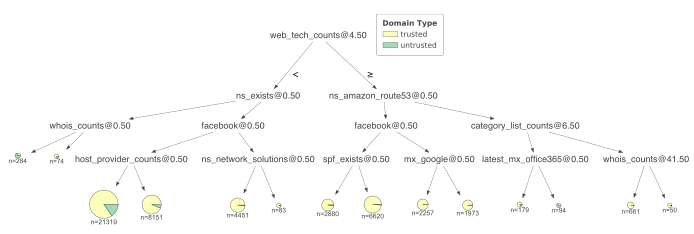

In [30]:
# viz = dtreeviz(classifier,
#               X_train,
#               y_viz,
#               target_name='Domain Type',
#               feature_names=X_train.columns, 
#               class_names=["trusted", "untrusted"],
#               fancy=False )  # fance=False to remove histograms/scatterplots from decision nodes
# viz

## Feature Importance

In [31]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for i in range(20):
    print(f"No.{i + 1} feature: {X.columns[indices[i]]} ({round(importances[indices[i]], 4)})")

Feature ranking:
No.1 feature: category_list_counts (0.0742)
No.2 feature: web_tech_counts (0.0714)
No.3 feature: whois_counts (0.0614)
No.4 feature: ns_exists (0.0526)
No.5 feature: host_provider_counts (0.0481)
No.6 feature: mail_provider_counts (0.0428)
No.7 feature: ns_amazon_route53 (0.0381)
No.8 feature: mx_exists (0.0364)
No.9 feature: ns_godaddy (0.0362)
No.10 feature: company_name_counts (0.0355)
No.11 feature: facebook (0.0351)
No.12 feature: app_list_exist (0.0291)
No.13 feature: registrar_counts (0.0291)
No.14 feature: spf_ends_in_inappropriate_all (0.0268)
No.15 feature: mx_internal (0.0209)
No.16 feature: twitter (0.0208)
No.17 feature: ns_network_solutions (0.0181)
No.18 feature: instagram (0.0172)
No.19 feature: spf_exists (0.0172)
No.20 feature: mx_google (0.0168)


# 3. Make predictions
----

## Predict on whole test set
Our model will make predictions on both the probabilities to be trusted or untrusted.  
The visualization below shows only the probability distribution for all the test set domains **to be trusted**

(array([5.000e+00, 6.400e+01, 9.000e+00, 3.600e+01, 5.200e+01, 2.320e+02,
        2.210e+02, 1.568e+03, 2.067e+03, 8.015e+03]),
 array([0.03226376, 0.12903738, 0.225811  , 0.32258463, 0.41935825,
        0.51613188, 0.6129055 , 0.70967913, 0.80645275, 0.90322638,
        1.        ]),
 <a list of 10 Patch objects>)

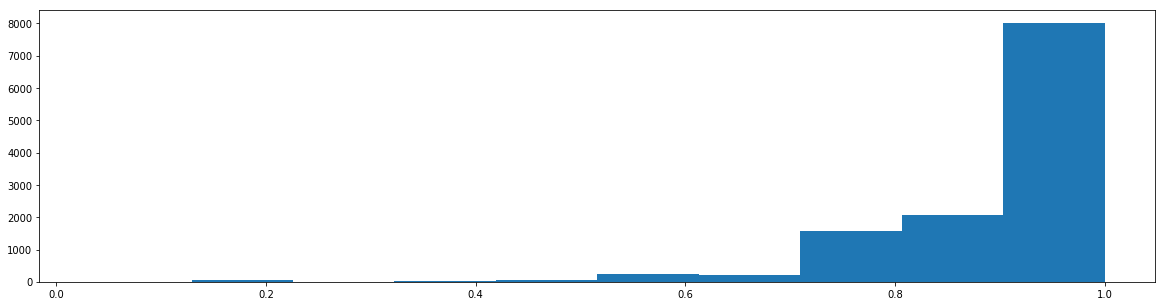

In [32]:
plt.rcParams['figure.figsize'] = [20, 5]
proba = rf.predict_proba(X_test)
good_prob = [p[0] for p in proba]
plt.hist(good_prob)

## Single prediction
Now Let's randomly choose a domain from the test set and make a soft prediction, i.e.
- generate a probability that this incoming domain is **to be trusted**

In [33]:
chosen_domain = X_test.sample(1)
chosen_domain

,whois_counts,company_name_counts,host_provider_counts,mail_provider_counts,registrar_counts,security_trail_exist,app_list_exist,category_list_counts,web_tech_counts,linkedin,...,ns_neustar,ns_noip,ns_ns1,ns_register_com,ns_sprint,ns_total_uptime,ns_verisign,ns_verizon,dmarc_easydmarc,ns_cloudflare
22292,0,0,0,0,0,0,1,11,11,0,...,0,0,0,0,0,0,0,0,0,0


### The actual label of this first domain from test set

In [34]:
chosen_idx = chosen_domain.index[0] # which is 81210
y_test[chosen_idx]

'trusted'

### Make a prediction

In [35]:
proba = rf.predict_proba(chosen_domain)
proba

array([[0.96966486, 0.03033514]])

In [36]:
print("The probability for the first domain to be trusted is", round(proba[0][0], 3))

The probability for the first domain to be trusted is 0.97


# Save & Load models
----

## Make directory in current folder to save our models

In [38]:
model_path = Path("./saved_models")
model_path.mkdir(parents=True, exist_ok=True)

In [39]:
lr_path = model_path/'LR_model.sav'
rf_path = model_path/'RF_model.sav'

### Save model to local directory

In [40]:
pickle.dump(lr, open(lr_path, 'wb'))
pickle.dump(rf, open(rf_path, 'wb'))

### Load the model from local directory

In [41]:
loaded_LR = pickle.load(open(lr_path, 'rb'))
loaded_RF = pickle.load(open(rf_path, 'rb'))

### Make predictions

In [42]:
pred = loaded_RF.predict_proba(X_test)